In [14]:
import torch.nn.functional as F
import torchvision
from torchvision.transforms.functional import to_pil_image
import torch
import matplotlib.pyplot as plt

In [15]:
device = torch.device("cuda")

In [16]:
def beta_scheduler(timesteps, start = 0.0001, end = 0.005):
    return torch.linspace(start, end, timesteps)

In [17]:
T = 200
IMG_SIZE = 64
BATCH_SIZE = 128
lr = 0.0002
betas = beta_scheduler(timesteps = T)

In [18]:
def get_index(vals, t, x_shape):
    b_size = t.shape[0]
    out = vals.gather(-1, t.cpu())

    return out.reshape(b_size, *((1,) * (len(x_shape) -1))).to(t.device)

In [19]:
def forward_diffusion(x_0, t, device = "cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_prod_t = get_index(sqrt_alphas_prod, t, x_0.shape)
    sqrt_one_minus_alphas_prod_t = get_index(sqrt_one_minus_alphas_prod, t, x_0.shape)

    return sqrt_alphas_prod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_prod_t.to(device) * noise.to(device), noise.to(device)

In [20]:
alphas = 1. - betas
alphas_prod = torch.cumprod(alphas, axis = 0)
alphas_prod_prev = F.pad(alphas_prod[:-1], (1, 0), value = 1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_prod = torch.sqrt(alphas_prod)
sqrt_one_minus_alphas_prod  = torch.sqrt(1. - alphas_prod)
posterior_variance = betas * (1. - alphas_prod_prev) / (1. - alphas_prod)

In [25]:
import kagglehub

data_path = kagglehub.dataset_download("subinium/emojiimage-dataset")
#data_path = "/kaggle/input/emojiimage-dataset"

print("Path to dataset files:", data_path)

Path to dataset files: /root/.cache/kagglehub/datasets/subinium/emojiimage-dataset/versions/2


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


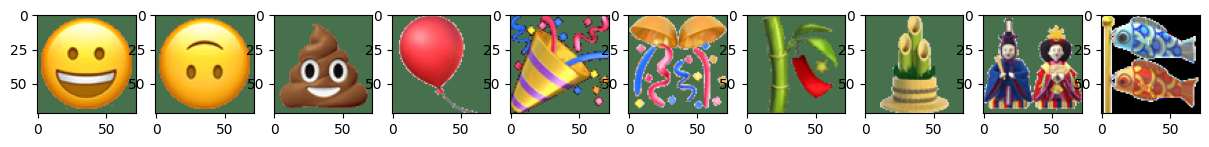

In [26]:
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

def show_images(datset, num_samples=10, cols=10):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = datasets.ImageFolder(root=data_path)
show_images(data)

In [27]:
def show_tensor(tensor):
    tensor = tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(tensor)

In [28]:
from torch.utils.data import DataLoader
import numpy as np

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t + 1.) / 2.)
    ]
    data_transform = transforms.Compose(data_transforms)

    train = datasets.ImageFolder(root=data_path, transform=data_transform)

    return train

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

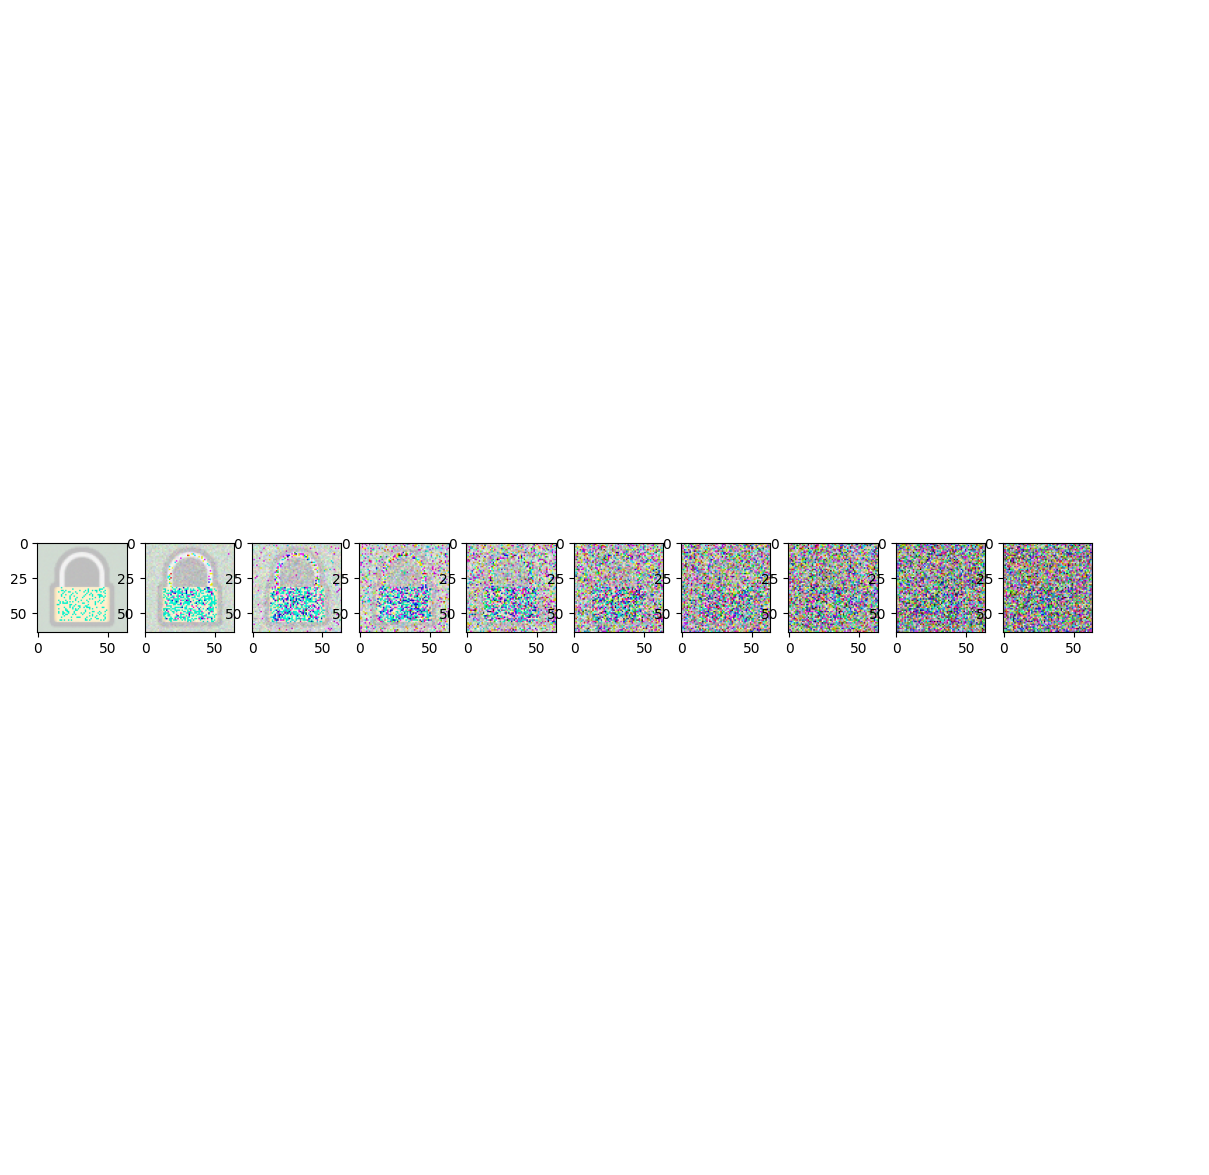

In [29]:
image = next(iter(dataloader))[0]
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).to(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion(image, t)
    show_tensor_image(img)

In [30]:
from torch import nn
import math

In [31]:
class UBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up = False):
        super().__init__()

        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding = 1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t, ):
        a = self.bn(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]

        a = a + time_emb
        a = self.bn(self.relu(self.conv2(a)))
        return self.transform(a)


In [32]:
class SinusoidoPositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):

        device = time.device
        half_dim = self.dim // 2

        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device = device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim = -1)

        return embeddings

In [33]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.image_ch = 3
        out_ch = 3
        time_emb_dim = 32
        down_chs = (64, 128, 256, 512)
        up_chs = (512, 256, 128, 64)

        self.time_mlp = nn.Sequential(
            SinusoidoPositionalEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )

        self.init = nn.Conv2d(self.image_ch, down_chs[0], 3, padding = 1)
        self.down = nn.ModuleList([UBlock(down_chs[i], down_chs[i + 1], time_emb_dim) for i in range(len(down_chs) - 1)])
        self.up = nn.ModuleList([UBlock(up_chs[i], up_chs[i + 1], time_emb_dim, True) for i in range(len(up_chs) - 1)])
        self.out = nn.Conv2d(up_chs[-1], out_ch, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.init(x)
        resids = []

        for d in self.down:
            x = d(x, t)
            resids.append(x)

        for u in self.up:
            resid = resids.pop()
            x = torch.cat((x, resid), dim = 1)
            x = u(x, t)

        return self.out(x)

In [34]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  15450979


UNet(
  (time_mlp): Sequential(
    (0): SinusoidoPositionalEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (init): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): UBlock(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): UBlock(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(256, 256, ker

In [35]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise_pred, noise)

In [36]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index(betas, t, x.shape)
    sqrt_one_minus_alphas_prod_t = get_index(
        sqrt_one_minus_alphas_prod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t) / sqrt_one_minus_alphas_prod_t
    )
    posterior_variance_t = get_index(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def evaluate():
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    plot_index = 1  # Start from 1
    for i in range(T - 1, -1, -1):  # same as reversed(range(T))
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, plot_index)
            show_tensor_image(img.detach().cpu())
            plot_index += 1

    plt.show()

In [37]:
from tqdm import tqdm

path = "practice_model_weights.pth"

In [38]:
loss_prog = torch.tensor([], device = device)

In [1]:
from torch.optim import AdamW
from torch.optim import SGD
device = 'cuda'
model.to(device)
model.train()
optimizer = AdamW(model.parameters(), lr=lr)
epochs = 4



low_loss = torch.tensor(torch.inf, device = device)

#model.load_state_dict(torch.load(path))
for epoch in range(epochs):
    for step, batch in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()

        acc_loss = 0

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        loss_prog = torch.cat((loss_prog, loss.detach().unsqueeze(0)), dim = -1)

        #if epoch % 5 == 0 and step == 0:
        if step % 400 == 0:
          if loss.detach() <= low_loss:
              low_loss = loss.detach()
          torch.save(model.state_dict(), path)


    print(f"Epoch {epoch} | Loss: {loss.item()} ")

NameError: name 'model' is not defined

In [41]:
import plotly.graph_objects as go

x = torch.linspace(0, loss_prog.size(0) - 1, steps=loss_prog.size(0))
y = loss_prog

x_np = x.numpy()
y_np = y.cpu().numpy()

fig = go.Figure()

fig.add_trace(go.Scatter(x=x_np, y=y_np, mode='lines', name='sin(x)'))

fig.update_layout(
    title='plot',
    xaxis_title='epochs',
    yaxis_title='losses',
    hovermode='closest'
)


fig.show()

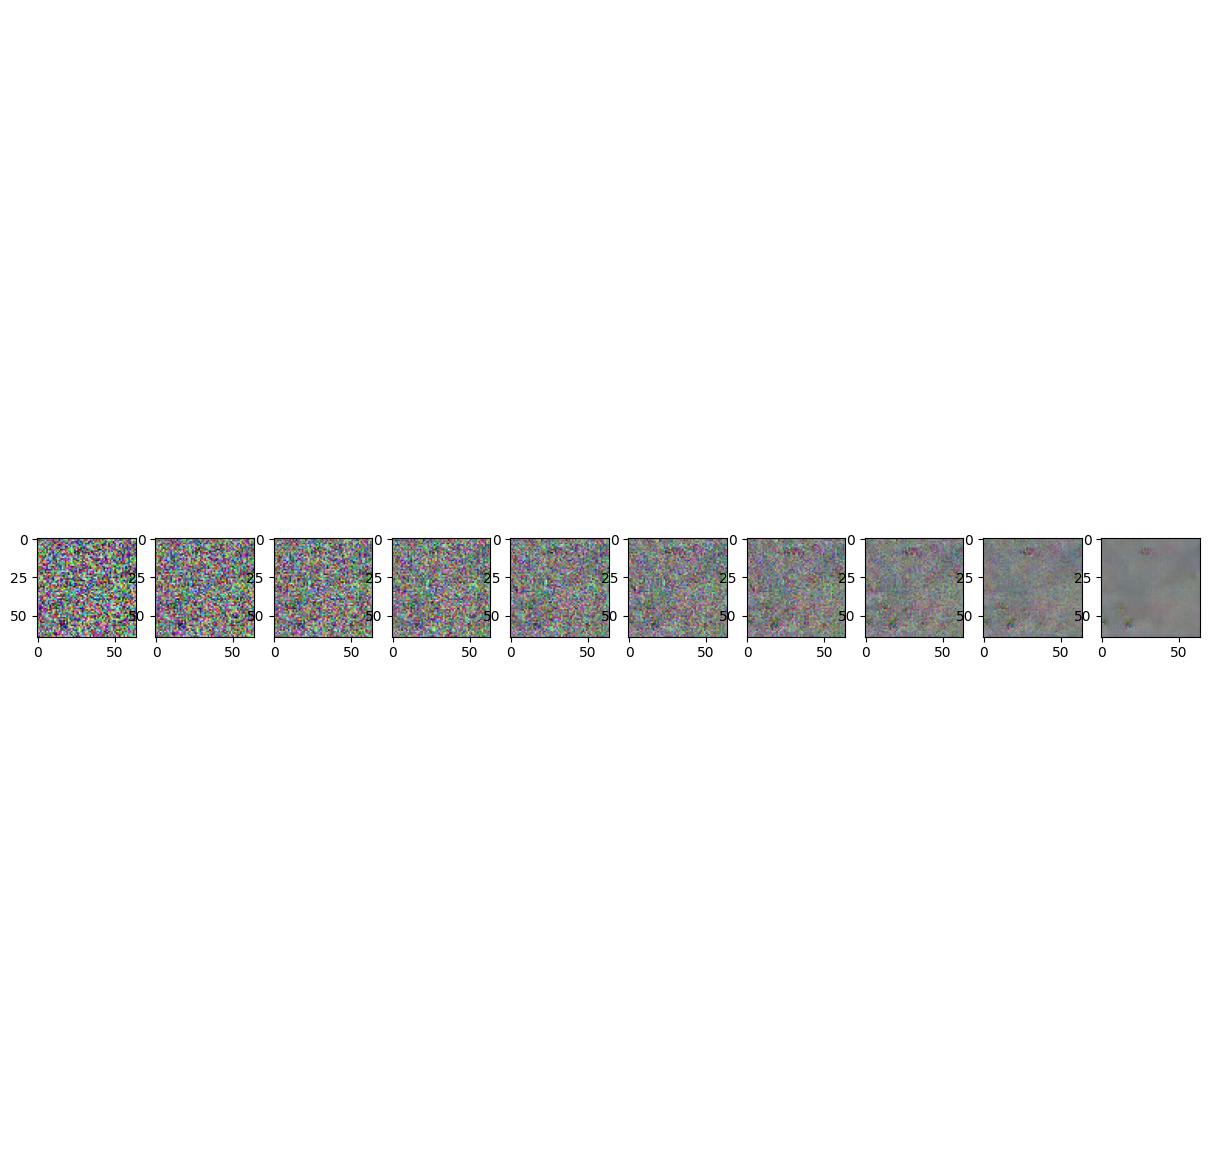

In [42]:
evaluate()